# (??) AD: boot corrs

**Motivation**: Define a cindition by its session and group label. Perform hierarchical bootstrap across animals, runs, and timepoints to get a single adjacency matrix per condition.  Then binarize this adjacency matrix by keeping top 10% of correlations.  Repeat.  After, say, $B=1000$ bootstraps, you will end up with a single weighted adjacency matrix per condition, where $a_{ij} = \frac{n_{ij}}{B}$ and $n_{ij}$ is the number of times this particular correlation survived the threshold. <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
mice = Mice(Config(192, resolution=25))

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [2]:
def decode_key(k):
    ssr = k.split('_')
    if len(ssr) == 3:
        sub, ses, run = ssr
    elif len(ssr) == 2:
        sub, ses = ssr
        run = None
    elif len(ssr) == 1:
        sub = ssr[-1]
        ses = None
        run = None
    if ses is not None:
        ses = int(ses.split('-')[-1])
    if run is not None:
        run = int(run.split('-')[-1])
    sub = sub.split('-')[-1]
    g = re.findall(f"[a-zA-Z]+", sub).pop()
    try:
        s = int(re.findall(f"[^a-zA-Z]+", sub).pop())
    except IndexError:
        s = None
    return g, s, ses, run



def do_group_tmp(data_dict, sessions: List[int], match_metric: str = 'correlation'):
    if not isinstance(sessions, Iterable):
        sessions = [sessions]
    data_list = list(itertools.chain.from_iterable([
        data_dict[ses] for ses in sessions]))
    data = np.concatenate([
        flatten_arr(x) for x in data_list])
    nonan = np.where(np.isnan(data).sum(0) == 0)[0]
    
    centroids = np.zeros((num_k, data.shape[-1]))
    _centroids, _ = fit_kmeans(
        data=data[:, nonan],
        n_clusters=num_k,
        match_metric='euclidean',
        random_state=42,
        kw_kmeans={
            'n_init': 10,
            'max_iter': 300,
            'tol': 0.0001},
    )
    centroids = np.zeros((num_k, data.shape[-1]))
    centroids[:, nonan] = _centroids
    
    global_mapping = bs.align_centroid_to_structs(
        pi_mv=centroids,
        metric='cosine',
        global_order=False,
    )
    centroids = centroids[global_mapping]
    
    pi = []
    for item in data_list:
        good = np.where(np.isnan(avg(item)).sum(0) == 0)[0]
        good = set(good).intersection(nonan)
        good = np.array(sorted(good))
        _x = item[..., good]
        _x = np.where(~np.isnan(_x), _x, 0.0)

        aligned = []
        for i, u in enumerate(_x):
            dist = sp_dist.cdist(
                XA=centroids[:, good],
                XB=u,
                metric=match_metric,
            )
            _, col_ind = sp_optim.linear_sum_assignment(dist)
            aligned.append(np.expand_dims(item[i][col_ind], 0))
        pi.append(np.concatenate(aligned))
    pi = np.concatenate(pi)
    pi /= np.nansum(pi, -2, keepdims=True)
    return pi

## Prepare

In [3]:
mice = Mice(128, load_parcel=True)
mice.set_band(band_bo=(0.008,0.28))

template, _ = mice.al.mcc.get_template_volume()
template = template.astype('uint32')
root = mice.al.get_masks('root')
brn = mice.parcel['brain'][:]
region_idxs = unique_idxs(brn)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

### Load node2id

In [4]:
n2i = np.load(pjoin(tmp_dir, 'AD_n2i.npy'), allow_pickle=True).item()
i2n = {i: n for n, i in n2i.items()}

n2l = {}
for n, i in n2i.items():
    info = mice.parcel.get(i)
    if info['acro'] == 'Isocortex':
        n2l[n] = f"{info['hemis']}-{info['region']}-{info['layer']}"
    else:
        n2l[n] = f"{info['hemis']}-{info['region']}"
mice.node_lookup['bold'] = n2l
mice.node_lookup['ca2'] = {
    n: lbl for n, lbl in n2l.items()
    if len(lbl.split('-')) == 3
}
bs = Base(mice, mode='ca2')

### Extract all keys

In [5]:
keys = []
for f in os.listdir(mice.cfg.svinet_dir):
    if f"n-{mice.cfg.nn}*{mice.cfg.ll}" not in f:
        continue
    key = f.split('_')
    try:
        i = next(
            i for i, e in
            enumerate(key)
            if 'sub' in e
        )
    except StopIteration:
        continue
    keys.append('_'.join(key[i:]))
keys = sorted(keys)
len(keys)

535

## SVINET

In [6]:
num_k = 5
kwargs = {
    'mice': mice,
    'num_k': num_k,
    'perc': 'p10-sample',
    'mode': 'bold',
    'verbpose': True,
}

### Fit all (once)

In [7]:
%%time

# for key in tqdm(keys):
#    sv = SVINET(key=key, **kwargs)
#    _ = sv.load_runs().fit_svinet()

  0%|          | 0/535 [00:00<?, ?it/s]

CPU times: user 2h 26min 55s, sys: 5min 1s, total: 2h 31min 57s
Wall time: 57min 39s


## WT vs DKI (session lvl)

In [7]:
wt = collections.defaultdict(list)
dki = collections.defaultdict(list)
for k in keys:
    g, s, ses, run = decode_key(k)
    if ses is None or run is not None:
        continue
    sv = SVINET(key=k, **kwargs).load_results()

    if g == 'WT':
        wt[ses].append(sv.gam_all)
    elif g == 'DKI':
        dki[ses].append(sv.gam_all)
    else:
        raise ValueError

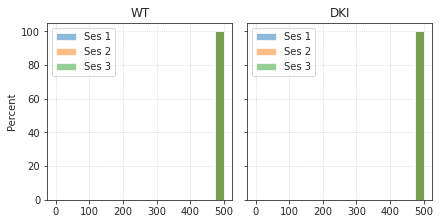

In [8]:
fig, axes = create_figure(1, 2, (6, 3), 'all', 'all', constrained_layout=True)

for ses in [1, 2 , 3]:
    sns.histplot(
        [x.shape[0] for x in wt[ses]],
        color=f'C{ses - 1}',
        bins=np.linspace(0, 500, 21),
        label=f'Ses {ses}',
        stat='percent',
        alpha=0.5,
        ax=axes[0],
    )
    sns.histplot(
        [x.shape[0] for x in dki[ses]],
        color=f'C{ses - 1}',
        bins=np.linspace(0, 500, 21),
        label=f'Ses {ses}',
        stat='percent',
        alpha=0.5,
        ax=axes[1],
    )
for ax in axes.flat:
    ax.legend()
    ax.grid()
axes[0].set_title('WT')
axes[1].set_title('DKI')
plt.show()

### Fir group

 Using ```correlation``` as match metric

In [9]:
%%time

pi_all_wt = do_group_tmp(wt, [1, 2, 3])
pi_all_dki = do_group_tmp(dki, [1, 2, 3])
pi_all_wt.shape, pi_all_dki.shape

CPU times: user 47min 18s, sys: 42.9 s, total: 48min 1s
Wall time: 1min 55s


((14500, 5, 2368), (19000, 5, 2368))

In [10]:
pi_wt = avg(pi_all_wt)
pi_dki = avg(pi_all_dki)

good = np.logical_and(
    np.isnan(pi_wt).sum(0) == 0,
    np.isnan(pi_dki).sum(0) == 0,
)
print(f"non nan nodes: {good.sum()}")

non nan nodes: 2339

In [11]:
d = sp_dist.cdist(
    XA=pi_wt[:, good],
    XB=pi_dki[:, good],
    metric='cosine',
)
_, col_ind = sp_optim.linear_sum_assignment(d)
pi_dki = pi_dki[col_ind]
col_ind

array([4, 1, 2, 3, 0])

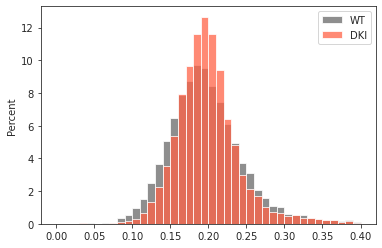

In [12]:
fig, ax = create_figure()
sns.histplot(
    pi_wt.ravel(),
    color='dimgrey',
    label='WT',
    stat='percent',
    bins=np.linspace(0, 0.4, 41),
    ax=ax,
)
sns.histplot(
    pi_dki.ravel(),
    color='tomato',
    label='DKI',
    stat='percent',
    bins=np.linspace(0, 0.4, 41),
    ax=ax,
)
ax.legend()
plt.show()

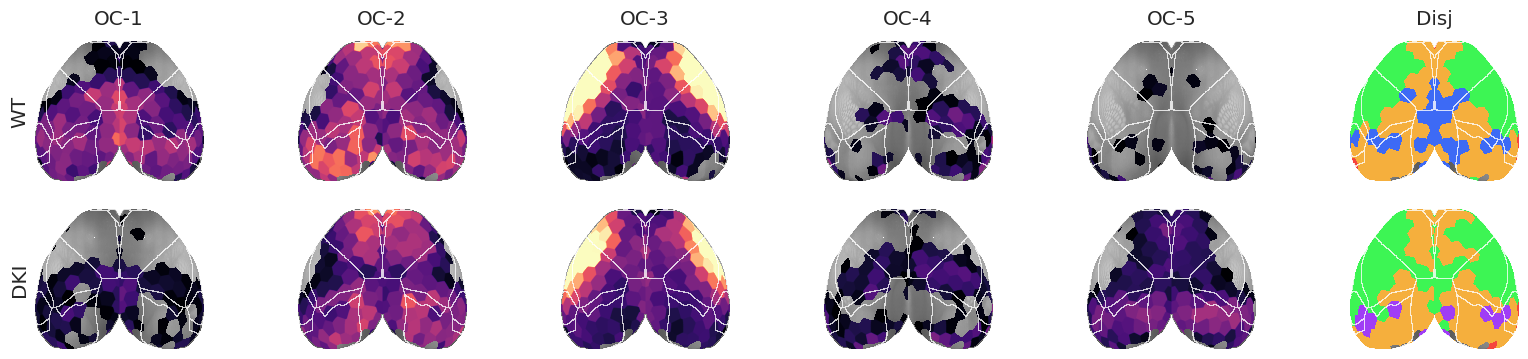

In [13]:
_ = bs.show(
    data={
        'WT': pi_wt,
        'DKI': pi_dki},
    vmin=0.15,
    vmax=0.4,
    mask_thresh=0.15,
    proj='top',
    contour=True,
    add_title=True,
    add_disjoint=True,
)

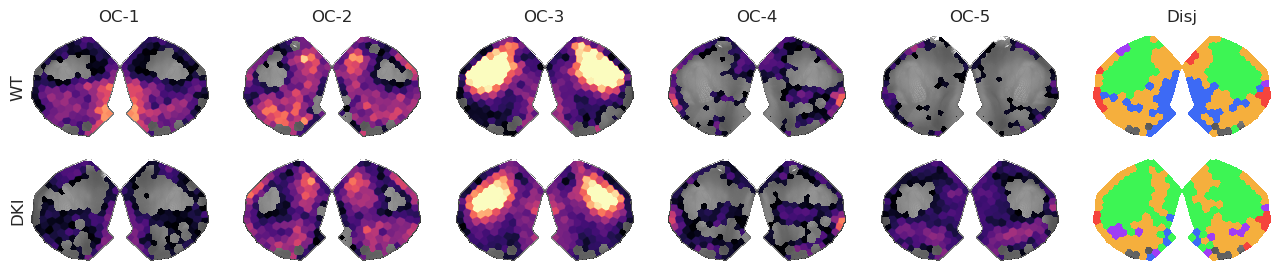

In [14]:
_ = bs.show(
    data={
        'WT': pi_wt,
        'DKI': pi_dki},
    vmin=0.15,
    vmax=0.4,
    mask_thresh=0.15,
    proj='flat',
    contour=False,
    add_title=True,
    add_disjoint=True,
    figsize=(16, 3),
)

In [15]:
sim = 1 - sp_dist.cdist(
    XA=pi_wt[:, good],
    XB=pi_dki[:, good],
    metric='correlation',
) / 2

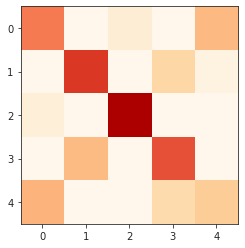

In [16]:
fig, ax = create_figure()
ax.imshow(sim, vmin=0.5, vmax=1, cmap='OrRd')
ax.locator_params(nbins=num_k+1)
plt.show()

In [17]:
pi_brn_wt = np_nans((num_k, *brn.shape))
pi_brn_dki = np_nans((num_k, *brn.shape))

for oc in range(num_k):
    for i, n in i2n.items():
        pi_brn_wt[oc].flat[region_idxs[i]] = pi_wt[oc, n]
        pi_brn_dki[oc].flat[region_idxs[i]] = pi_dki[oc, n]

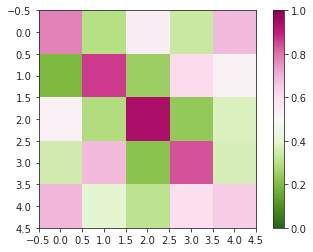

In [18]:
fig, ax = create_figure()
im = ax.imshow(sim, vmin=0.0, vmax=1, cmap='PiYG_r')
ax.locator_params(nbins=11)
plt.colorbar(im, ax=ax)
plt.show()

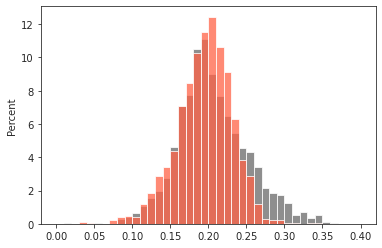

In [21]:
oc = 0
sns.histplot(pi_wt[oc], color='dimgrey', stat='percent', bins=np.linspace(0, 0.4, 41))
sns.histplot(pi_dki[oc], color='tomato', stat='percent', bins=np.linspace(0, 0.4, 41));

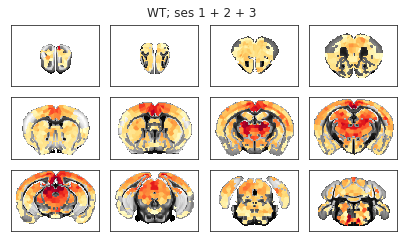

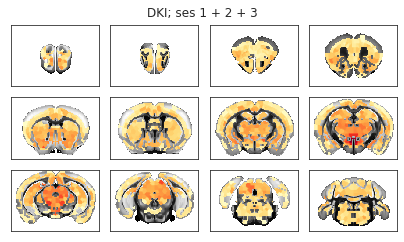

In [22]:
slices = range(10, 111, 9)

thres = 0.15
vmin = 0.15
vmax = 0.35
interp = 'antialiased'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_wt[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_dki[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

In [180]:
slices = range(10, 111, 9)
ncols = len(slices)

In [181]:
fig = plt.figure(figsize=(38, 4.45))
gs = GridSpec(
    nrows=2,
    ncols=ncols + 2,
    width_ratios=[1]*ncols + [0.02, 0.1],
    wspace=0.04,
    hspace=0.04,
)

In [182]:
for j, s_ in enumerate(slices):
    for i, (k, v) in enumerate({
        'WT': pi_brn_wt,
        'DKI': pi_brn_dki,
    }.items()):
        x2p = v[oc][s_]
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.annotate(
                text=s_,
                xy=(0.01, 0.9),
                xycoords='axes fraction',
                color='dimgrey',
            )
        ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
        im = ax.imshow(
            X=mwh(x2p < thres, x2p),
            cmap='YlOrRd',
            vmin=vmin,
            vmax=vmax,
            interpolation=interp,
        )
        remove_ticks(ax, False)
cax = fig.add_subplot(gs[:2, -1])
plt.colorbar(im, cax=cax)
plt.close()

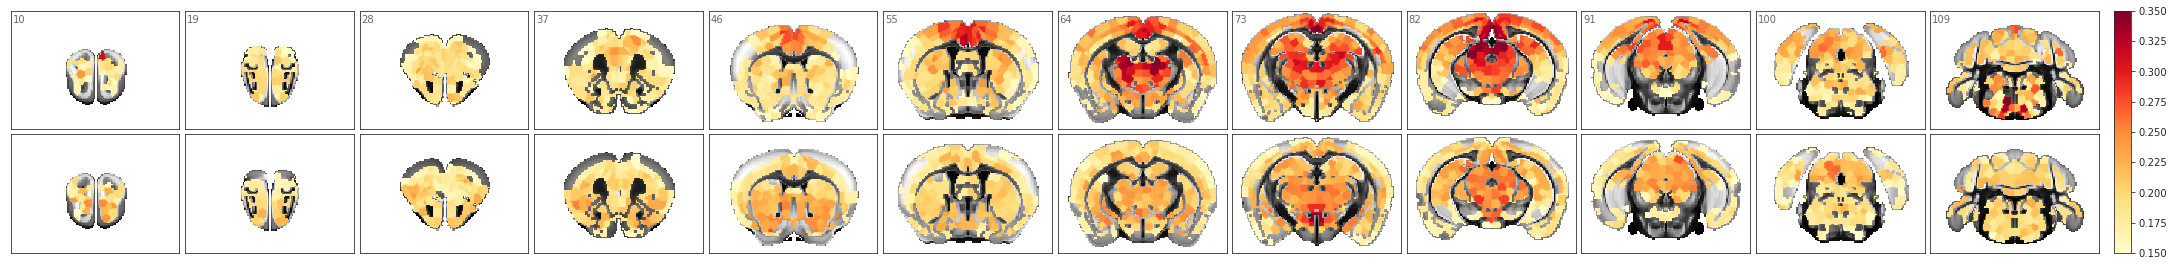

In [183]:
fig

<matplotlib.image.AxesImage object at 0x7f13e3880640>

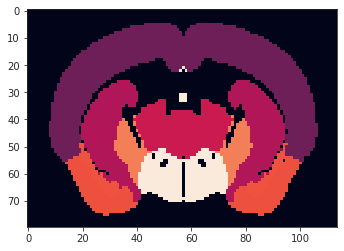

In [185]:
plt.imshow(major[60])

In [243]:
major_structs = mice.al.get_major_12()
major = mice.al.get_masks(major_structs, as_objectmap=True)
for i_new, i in enumerate(np.unique(major[major.nonzero()])):
    major[major == i] = i_new + 1

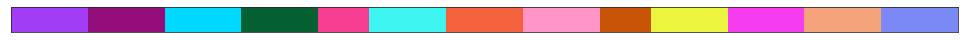

In [244]:
# major_cmap = sns.color_palette("Accent", as_cmap=True, )
major_cmap = get_cluster_cmap(range(4, 4 + len(major_structs)))
display_cmap(major_cmap)

In [245]:
fig = plt.figure(figsize=(38, 6.7))
gs = GridSpec(
    nrows=3,
    ncols=ncols + 2,
    width_ratios=[1]*ncols + [0.02, 0.1],
    wspace=0.04,
    hspace=0.04,
)
for j, s_ in enumerate(slices):
    for i, (k, v) in enumerate({
        'WT': pi_brn_wt,
        'DKI': pi_brn_dki,
    }.items()):
        x2p = v[oc][s_]
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.annotate(
                text=s_,
                xy=(0.01, 0.9),
                xycoords='axes fraction',
                color='dimgrey',
            )
        ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
        im = ax.imshow(
            X=mwh(x2p < thres, x2p),
            cmap='YlOrRd',
            vmin=vmin,
            vmax=vmax,
            interpolation=interp,
        )
        remove_ticks(ax, False)
    ax = fig.add_subplot(gs[-1, j])
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = major[s_]
    ax.imshow(
        X=mwh(x2p == 0, x2p),
        cmap=major_cmap,
        vmin=1,
        vmax=len(major_structs),
        interpolation='none',
    )
    remove_ticks(ax, True) 

cax = fig.add_subplot(gs[:2, -1])
plt.colorbar(im, cax=cax)
plt.close()

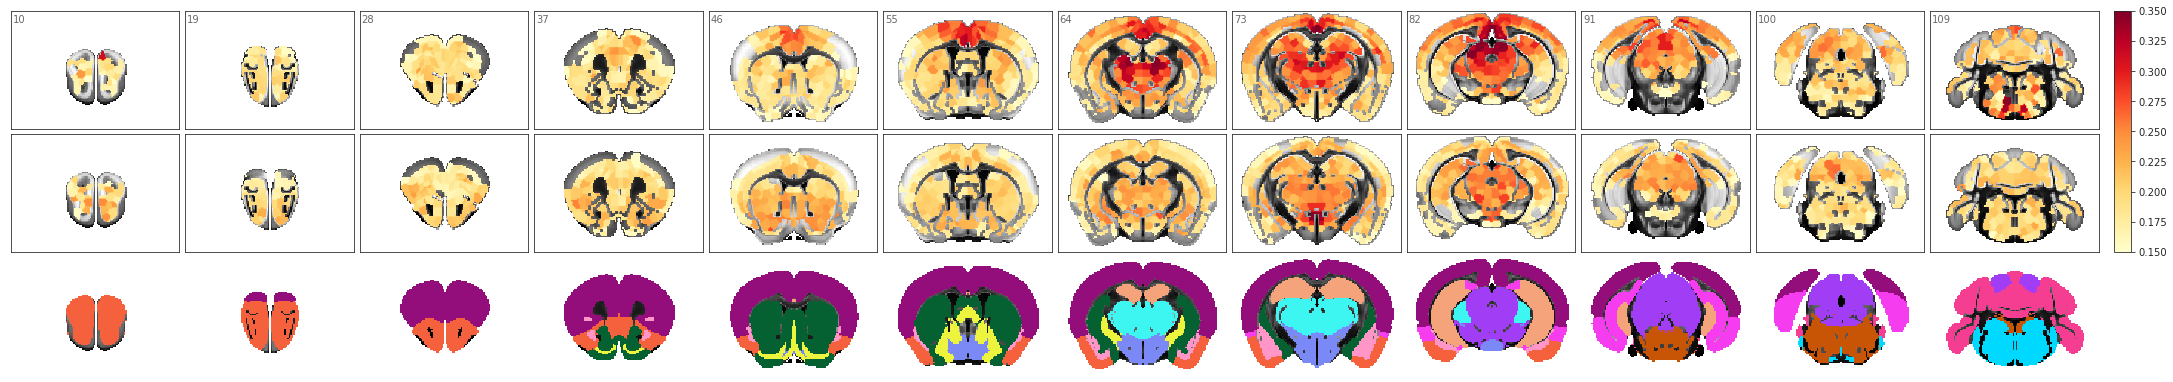

In [246]:
fig

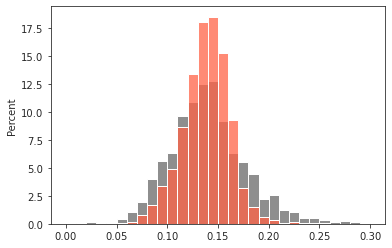

In [23]:
oc = 3
sns.histplot(pi_wt[oc], color='dimgrey', stat='percent', bins=np.linspace(0, 0.3, 31))
sns.histplot(pi_dki[oc], color='tomato', stat='percent', bins=np.linspace(0, 0.3, 31));

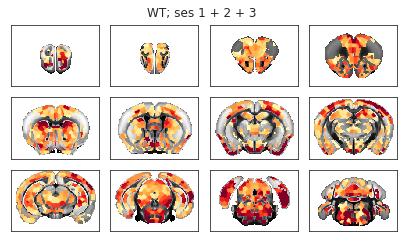

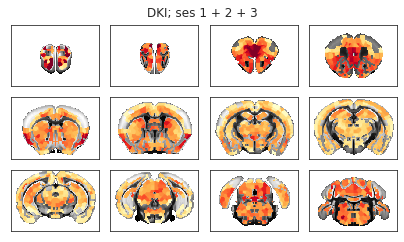

In [24]:
slices = range(10, 111, 9)

thres = 0.1
vmin = 0.1
vmax = 0.2
interp = 'antialiased'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_wt[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_dki[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

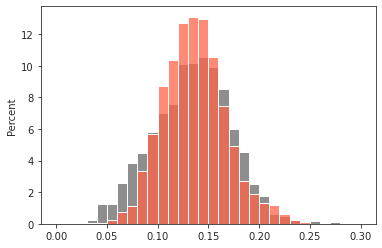

In [25]:
oc = 4
sns.histplot(pi_wt[oc], color='dimgrey', stat='percent', bins=np.linspace(0, 0.3, 31))
sns.histplot(pi_dki[oc], color='tomato', stat='percent', bins=np.linspace(0, 0.3, 31));

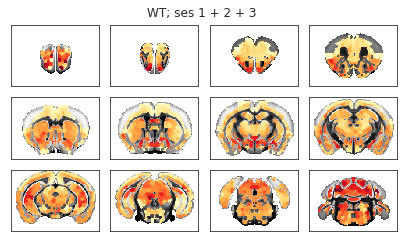

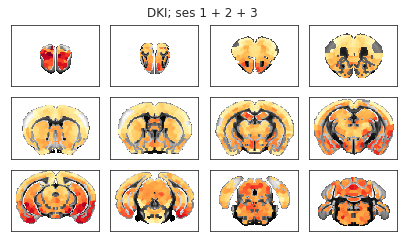

In [26]:
slices = range(10, 111, 9)

thres = 0.07
vmin = 0.07
vmax = 0.25
interp = 'antialiased'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_wt[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_dki[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

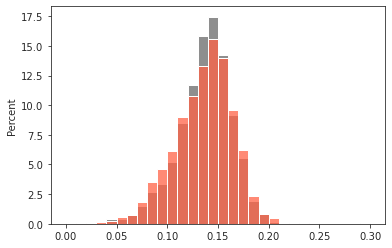

In [27]:
oc = 6
sns.histplot(pi_wt[oc], color='dimgrey', stat='percent', bins=np.linspace(0, 0.3, 31))
sns.histplot(pi_dki[oc], color='tomato', stat='percent', bins=np.linspace(0, 0.3, 31));

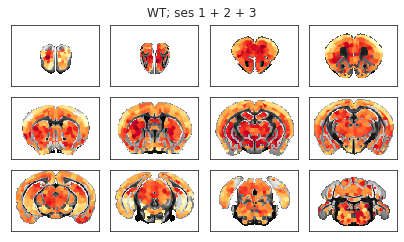

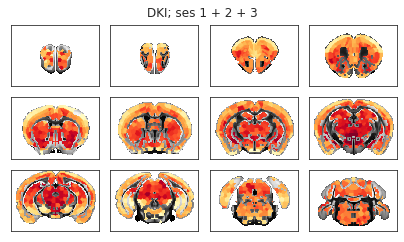

In [28]:
slices = range(10, 111, 9)

thres = 0.07
vmin = 0.07
vmax = 0.20
interp = 'antialiased'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_wt[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_dki[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

In [46]:
partition_wt = bs.get_disjoint_community(pi_wt)
partition_dki = bs.get_disjoint_community(pi_dki)
np.unique(partition_wt[good]), np.unique(partition_dki[good])

(array([1., 2., 3., 4., 5., 6., 7.]), array([1., 2., 3., 4., 5., 6., 7.]))

In [51]:
partition_brn_wt = np_nans(brn)
partition_brn_dki = np_nans(brn)

for i, n in i2n.items():
    partition_brn_wt.flat[region_idxs[i]] = partition_wt[n]
    partition_brn_dki.flat[region_idxs[i]] = partition_dki[n]

In [52]:
cmap = get_cluster_cmap(range(num_k))

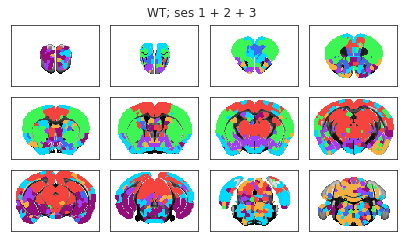

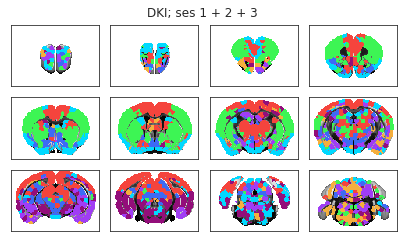

In [54]:
slices = range(10, 111, 9)

thres = 0.0
vmin = 1
vmax = num_k + 1
interp = 'none'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = partition_brn_wt[s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = partition_brn_dki[s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

## Conclusion: for now use session level

Now running the following:

```bash
time ./loop_svinet.sh 128 3 7 p10-sample 500 bold rest “0.008,0.28” pearson “sub-[0-9A-Z]*_ses-[1-9]”
time ./loop_svinet.sh 128 3 7 p5-sample 500 bold rest “0.008,0.28” pearson “sub-[0-9A-Z]*_ses-[1-9]”
time ./loop_svinet.sh 128 3 5 p10-sample 500 bold rest “0.008,0.28” pearson “sub-[0-9A-Z]*_ses-[1-9]”
```

In [135]:
cnt = []
for f in sorted(os.listdir(mice.cfg.svinet_dir)):
    files = pjoin(mice.cfg.svinet_dir, f, 'real', 'p10-sample')
    files = sorted(os.listdir(files))
    cnt.append(len(files) - 1)
cnt = collections.Counter(cnt)
cnt

Counter({0: 419, 1000: 118})

In [248]:
cnt = []
for f in sorted(os.listdir(mice.cfg.svinet_dir)):
    files = pjoin(mice.cfg.svinet_dir, f, 'real', 'p10-sample')
    files = sorted(os.listdir(files))
    cnt.append(len(files) - 1)
cnt = collections.Counter(cnt)
cnt

Counter({0: 419, 1000: 117, 1028: 1})

In [250]:
mice = Mice(Config(192, resolution=25))

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [ ]:
%%time

mice.parcel.fit_parcel(True)

[PROGRESS] fit columnar: initiated

[PROGRESS] kmeans fit: done

[PROGRESS] save 2D 10um: done

[PROGRESS] 2d --> 3d: done

[PROGRESS] save 3D 10um: done